In [1]:
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# modeling
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# other
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)

np.random.seed(42)

# HW3 - Payment Classification

By Corentin Llorca (cl3783) and Costas Vafeades (cv2451)

Goal is to predict whether a payment by a company to a medical doctor or facility was made as part of a research project or not. All relevant data can be found [here](https://www.cms.gov/OpenPayments/Explore-the-Data/Dataset-Downloads.html).

### Data Description

Physicians may be identified as covered recipients of records or as principal investigators associated with research-related payment records. Teaching hospitals may also be identified as covered recipients. Teaching hospitals are defined as any hospital receiving payments for GM, IPPS or IME. 


Each record in the General Payment, Research Payment, and Ownership/Investment files includes a Change Type indicator field. 
- NEW: the record is newly reported by the reporting entity since the last publication and is being published for the first time.
- ADD: the record is not new in the system but, due to the record not being eligible for publication until the current publication cycle, is being published for the first time.
- CHANGED: record was previously published but has been modified since its last publication. A record whose only change since the last publication is a change to its dispute status is categorized as a changed record.
- UNCHANGED: record was published during the last publication cycle and is being republished without change in the current publication. 

## Task 1: Identify Features

First of all, let's load the data to assemble the dataset. The data comes from two different csv files, OP_DTL_GNRL_PGYR2017_P01182019.csv (general payments) and OP_DTL_RSRCH_PGYR2017_P01182019.csv (research payments), so we load a subsample of those two files, add the target feature "research_payment" (0 for rows in the first file and 1 for rows in the second file) and concatenate them. 

### How do we balance classes? 

The data is naturally imbalanced, as there are much more records of general payments than research payments. Here are the row counts for both files: 

In [2]:
n_gen = sum(1 for line in open('data\OP_DTL_GNRL_PGYR2017_P01182019.csv')) - 1
n_res = sum(1 for line in open('data\OP_DTL_RSRCH_PGYR2017_P01182019.csv')) - 1
# the -1 is to exclude header

print("General payments: " + str(n_gen) + " lines")
    
print("Research payments: " + str(n_res) + " lines")

General payments: 10663833 lines
Research payments: 602530 lines


Since the general payments csv is way too large to load, we will select a subsample of the rows for each csv, forming the whole dataset. We have the choice of how many rows to select in each file, and the choice we make will end up deciding the class balance. Here are the two options we have: 
* Select an equal number of rows for both classes: this completely removes class imbalance and the problems it might cause. However, we lose the "real-world setting" with imbalanced classes

* Select a number of rows in each file that's proportionate to their total number of rows: this will cause class imbalance problems since there is an approximate 95% / 5% class distribution, but will reflect the whole problem better.

We ended up choosing the former. 

### Loading and joining the datasets

We first load the separate datasets and add the target feature. To load the data, we do a random subsampling.

In [3]:
# Number of desired samples for each file
nsamples_gen = 10000
nsamples_res = 10000

skiprows_gen = np.sort(np.random.choice(range(1, n_gen+1), replace = False, size = n_gen - nsamples_res))
skiprows_res = np.sort(np.random.choice(range(1, n_res+1), replace = False, size = n_res - nsamples_res))

gen = pd.read_csv("data\OP_DTL_GNRL_PGYR2017_P01182019.csv", skiprows = skiprows_gen, parse_dates=['Date_of_Payment'])
res = pd.read_csv("data\OP_DTL_RSRCH_PGYR2017_P01182019.csv", skiprows = skiprows_res, parse_dates=['Date_of_Payment'])

gen['research_payment'] = 0
res['research_payment'] = 1

#### Concatenation

The next problem is to concatenate the data. This raises an issue: our two data files have different columns - but also have a lot of columns in common. The "baseline" choice here would be to simply use panda's concatenate function, which would give us a concatenated dataset, whose columns would be the union of the columns of the two separated datasets, filling the missing values with NA. 

However, this creates a problem: since the two separated datasets are also the two separated classes, then if one feature is only non-missing in one of the classes, it might indirectly reveal information about the class to the model, in an unwanted way (data leakage). The solution to that is to only keep the features that are in both datasets when concatenating (inner join instead of outer join).

In [206]:
df = pd.concat([gen, res], join='inner')

### Data Types

We need to check that pandas has loaded the right data types for our dataframe. Printing the dtypes shows us a few irregularities, namely that there are ID features that are counted as floats/ints when they should be used as categoricals. Other than that, there seems to be no problem. We notice, by looking at the dtypes, that the whole dataset has only one continuous variable (Total_Amount_of_Payment_USDollars).

In [207]:
to_cat = ['Teaching_Hospital_CCN', 'Teaching_Hospital_ID',
          'Physician_Profile_ID', 'Physician_License_State_code5',
          'Record_ID', 'Program_Year', 'research_payment']
df = df.astype(dtype={v: object for v in to_cat}, copy=False)

### Checking for Data Leakage and Irrelevant Features

Before we proceed, it's important to check the values of each of our variables to make sure that they don't leak the target and also remove irrelevant features. 

In [208]:
df.groupby('research_payment').nunique()

,Change_Type,Covered_Recipient_Type,Teaching_Hospital_CCN,Teaching_Hospital_ID,Teaching_Hospital_Name,Physician_Profile_ID,Physician_First_Name,Physician_Middle_Name,Physician_Last_Name,Physician_Name_Suffix,Recipient_Primary_Business_Street_Address_Line1,Recipient_Primary_Business_Street_Address_Line2,Recipient_City,Recipient_State,Recipient_Zip_Code,Recipient_Country,Recipient_Province,Recipient_Postal_Code,Physician_Primary_Type,Physician_Specialty,Physician_License_State_code1,Physician_License_State_code2,Physician_License_State_code3,Physician_License_State_code4,Physician_License_State_code5,Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State,Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country,Total_Amount_of_Payment_USDollars,Date_of_Payment,Form_of_Payment_or_Transfer_of_Value,Delay_in_Publication_Indicator,Record_ID,Dispute_Status_for_Publication,Related_Product_Indicator,Covered_or_Noncovered_Indicator_1,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1,Product_Category_or_Therapeutic_Area_1,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1,Associated_Drug_or_Biological_NDC_1,Covered_or_Noncovered_Indicator_2,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2,Product_Category_or_Therapeutic_Area_2,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_2,Associated_Drug_or_Biological_NDC_2,Covered_or_Noncovered_Indicator_3,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_3,Product_Category_or_Therapeutic_Area_3,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_3,Associated_Drug_or_Biological_NDC_3,Covered_or_Noncovered_Indicator_4,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_4,Product_Category_or_Therapeutic_Area_4,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_4,Associated_Drug_or_Biological_NDC_4,Covered_or_Noncovered_Indicator_5,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5,Product_Category_or_Therapeutic_Area_5,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_5,Associated_Drug_or_Biological_NDC_5,Program_Year,Payment_Publication_Date,research_payment
research_payment,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3,2,30,30,28,9590,3359,1067,7036,20,8855,1511,2975,52,7152,1,0,0,6,171,52,43,21,6,0,427,464,464,37,10,4080,352,3,1,10000,1,2,2,4,529,1306,553,2,4,166,356,209,2,3,102,185,112,2,3,47,66,39,1,3,19,26,13,1,1,1
1,3,4,1108,1123,363,385,253,81,343,5,5438,1216,1637,52,2864,3,2,3,5,73,39,4,0,0,0,240,279,282,32,17,5853,319,2,1,10000,2,2,2,4,284,709,366,2,3,26,38,18,1,3,16,20,8,1,3,9,10,2,1,3,6,7,2,1,1,1


We can remove Record_ID as that's a unique identifier of each observation.

In [209]:
cols_drop = ['Record_ID']

Variables that have the same unique value for both research and non-research payments can be considered as irrelevant and be dropped.

In [210]:
for v in df.columns.values[:-1]:
    if len(df[v].unique()) == 1:
        cols_drop.append(v)

df.drop(cols_drop, axis=1, inplace=True)

Variables that have only one value for either of the two types of payments should be investigated further. 

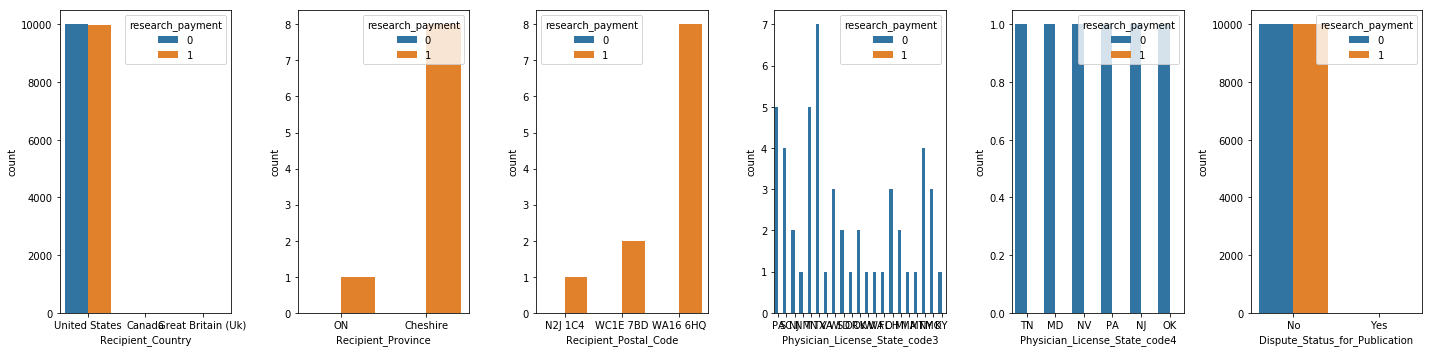

In [211]:
cols_drop = []
for v in df.columns.values[:-1]:
    for i in range(2):
        if len(df[df['research_payment'] == i][v].unique()) == 1:
            if v not in cols_drop: cols_drop.append(v)

                
fig, ax = plt.subplots(1, len(cols_drop), figsize = (20, 5))
i=0
for v in cols_drop:
    sns.countplot(v, hue='research_payment', data = df, ax = ax[i])
    i+=1

plt.tight_layout()

In [212]:
df.drop(cols_drop, axis=1, inplace=True)

#### Sparse Variables

A big portion of our features don't have any data for one of the targets. 

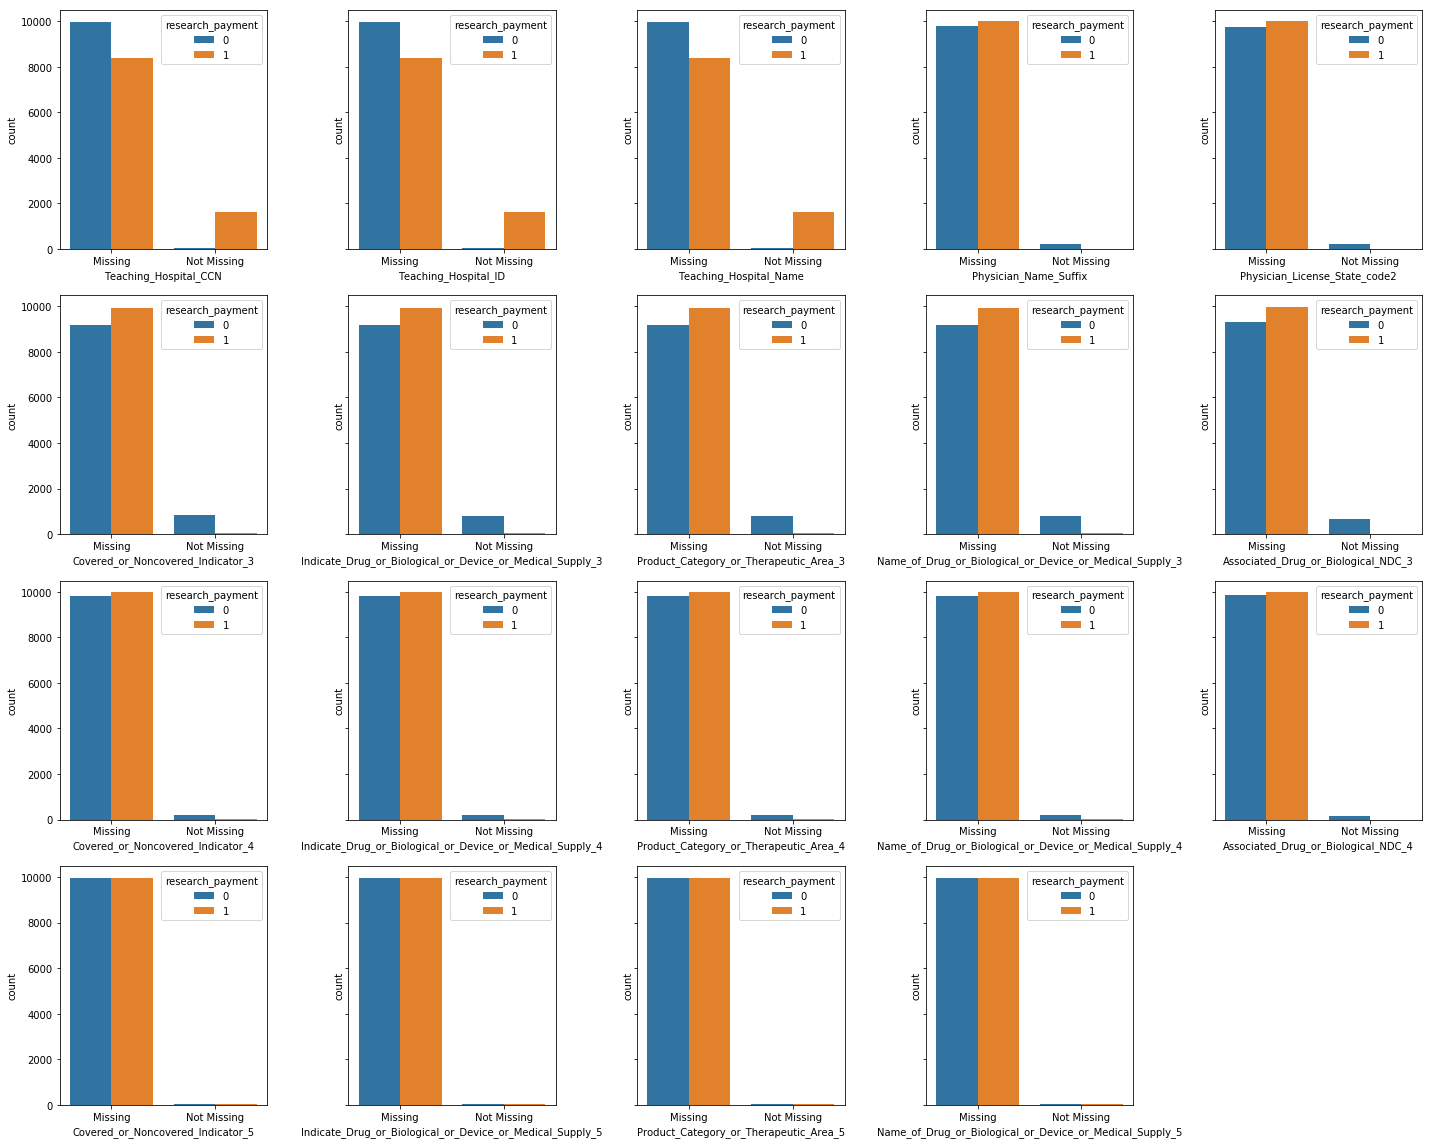

In [213]:
df_missing = df.copy()
for c in df_missing.columns[:-1]:
    df_missing[c] = np.where(df_missing[c].isnull(), 'Missing', 'Not Missing')

fig, ax = plt.subplots(4, 5, figsize = (20, 16), sharey='row')
cols_drop = []
# axis indicators
i = 0
j = 0

for v in df_missing.columns.values[:-1]:
    if df_missing[df_missing[v] == 'Missing'].shape[0] > (df_missing.shape[0] * 0.9):
        sns.countplot(v, hue='research_payment', data = df_missing, ax=ax[j, i])
        cols_drop.append(v)
        # increment axis
        i += 1
        if i == 5: j += 1; i = 0
        
        
fig.delaxes(ax[3, 4])
plt.tight_layout()
plt.show()

In [214]:
cols_drop.remove('Teaching_Hospital_ID')
df.drop(cols_drop, axis=1, inplace=True)

####  Leaky Variables

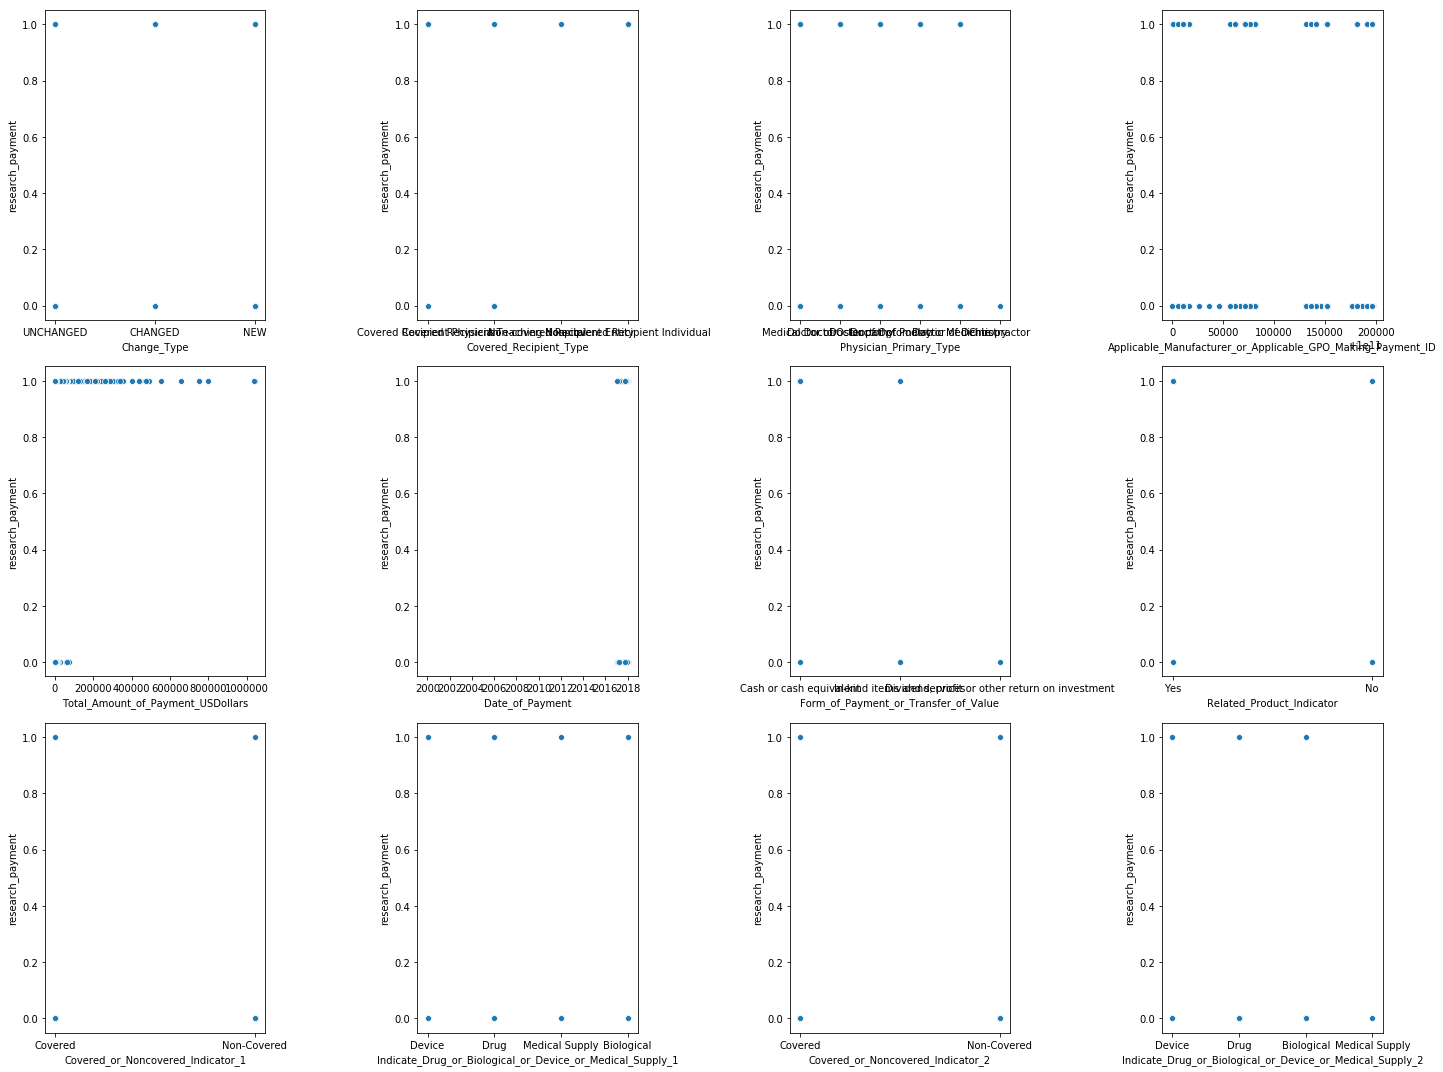

In [215]:
fig, ax = plt.subplots(3, 4, figsize=(20, 15))
i = 0
j = 0

for c in df.columns.values[:-1]:
    if (len(df[c].unique()) <= 10) | (df[c].dtype != object):
        sns.scatterplot(x=c, y='research_payment', data=df, ax=ax[j, i])
        
        i+=1
        if i == 4: j+=1; i=0
        
plt.tight_layout()
plt.show()

Judging by the plots above, the variables Covered_Recipient_Type, Physician_Primary_Type and Form_of_Payment_or_Transfer_of_Value could be leaking the target. It's important to investigate these further before proceeding.

**Covered_Recipient_Type**

In [216]:
df.groupby(['research_payment', 'Covered_Recipient_Type']).size().reset_index()

,research_payment,Covered_Recipient_Type,0
0,0,Covered Recipient Physician,9970
1,0,Covered Recipient Teaching Hospital,30
2,1,Covered Recipient Physician,394
3,1,Covered Recipient Teaching Hospital,1612
4,1,Non-covered Recipient Entity,7983
5,1,Non-covered Recipient Individual,11


Given that the proportions are very different for each of our targets, this raises further suspicions. General payments are only made to covered recipients so we can remove this variable as it's better to be safe than sorry. 

In [217]:
df.drop('Covered_Recipient_Type', axis=1, inplace=True)

**Physician_Primary_Type**

In [218]:
df.groupby(['research_payment', 'Physician_Primary_Type']).size().reset_index()

,research_payment,Physician_Primary_Type,0
0,0,Chiropractor,1
1,0,Doctor of Dentistry,281
2,0,Doctor of Optometry,212
3,0,Doctor of Osteopathy,869
4,0,Doctor of Podiatric Medicine,109
5,0,Medical Doctor,8498
6,1,Doctor of Dentistry,5
7,1,Doctor of Optometry,6
8,1,Doctor of Osteopathy,16
9,1,Doctor of Podiatric Medicine,4


The proportions here also raise an eye, but the values don't seem to give away the target.

**Form_of_Payment_or_Transfer_of_Value**

In [219]:
df.groupby(['research_payment', 'Form_of_Payment_or_Transfer_of_Value']).size().reset_index()

,research_payment,Form_of_Payment_or_Transfer_of_Value,0
0,0,Cash or cash equivalent,1539
1,0,"Dividend, profit or other return on investment",1
2,0,In-kind items and services,8460
3,1,Cash or cash equivalent,7892
4,1,In-kind items and services,2108


Again, the proportions are very different for each payment type but it doesn't seem to be a dead giveaway. 

#### Irrelevant Variables

After a quick scan of the remaining variables, we can remove those that don't or at least shouldn't have anything to do with the target. 

In [220]:
cols_drop = ['Physician_First_Name', 'Physician_Middle_Name', 'Recipient_Primary_Business_Street_Address_Line2']
df.drop(cols_drop, axis=1, inplace=True)

#### Renaming our Variables

In [221]:
df = df.rename(index=str, columns={'Teaching_Hospital_ID': 'hospital',
                                 'Physician_Profile_ID': 'phy_ID',
                                 'Physician_First_Name': 'phy_first_name',
                                 'Physician_Last_Name': 'phy_last_name',
                                 'Recipient_Primary_Business_Street_Address_Line1': 'address',
                                 'Recipient_City': 'city',
                                 'Recipient_State': 'state',
                                 'Recipient_Zip_Code': 'zip_code',
                                 'Physician_Primary_Type': 'phy_primary_type',
                                 'Physician_Specialty': 'phy_specialty', 
                                 'Physician_License_State_code1': 'phy_state',
                                 'Submitting_Applicable_Manufacturer_or_Applicable_GPO_Name': 'submitting_GPO_name',
                                 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Name': 'paying_GPO_name',
                                 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_State': 'paying_GPO_state',
                                 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_Country': 'paying_GPO_country',
                                 'Applicable_Manufacturer_or_Applicable_GPO_Making_Payment_ID': 'paying_GPO_ID',
                                 'Total_Amount_of_Payment_USDollars': 'payment_amount',
                                 'Date_of_Payment': 'payment_date',
                                 'Form_of_Payment_or_Transfer_of_Value': 'payment_form',
                                 'Covered_or_Noncovered_Indicator_1': 'product1_covered',
                                 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_1': 'product1_type',
                                 'Product_Category_or_Therapeutic_Area_1': 'product1_category',
                                 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_1': 'product1_name',
                                 'Associated_Drug_or_Biological_NDC_1': 'product1_associated',
                                 'Covered_or_Noncovered_Indicator_2': 'product2_covered',
                                 'Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_2': 'product2_type',
                                 'Product_Category_or_Therapeutic_Area_2': 'product2_category',
                                 'Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_2': 'product2_name',
                                 'Associated_Drug_or_Biological_NDC_2': 'product2_associated'})

## Task 2: Preprocessing and baseline model

For the simple minimum viable model, we've decided to do logistic regression with a very limited number of features. The filter we've applied to features is the following (those are very "harsh" filters but again, this is a baseline model).
* Drop all features with more than 10% missing data (considered "sparse")
* Drop all categorical features with too many categories since we're going to one-hot encode them. We've chosen 200 (1% of the number of data points) as a threshold

In [222]:
cols_drop2 = list(df.columns[df.isnull().sum() > 0.1*df.shape[0]])
cats = df.columns[df.dtypes == object]
cols_drop2.extend(cats[df[cats].nunique() > 0.01*df.shape[0]])
df2 = df.drop(set(cols_drop2), axis=1)
df2.columns

Index(['Change_Type', 'state', 'paying_GPO_ID', 'paying_GPO_state',
       'paying_GPO_country', 'payment_amount', 'payment_date', 'payment_form',
       'Related_Product_Indicator', 'product1_covered', 'research_payment'],
      dtype='object')

As we can see, we're left with only a few features, only one of which is continuous. We can now set up a baseline model, with basic preprocessing: we're only going to one-hot encode the categorical variables.

We assign the "missing" category to missing values in categorical variables (such treatment normally shouldn't be done on X directly, but here it doesn't imply data leakage so it's OK). No treatment is needed for the continuous variable since it has no missing value. We then split training and test set.

We also need to change y to -1 and 1.

In [223]:
X = df2.drop('research_payment', axis=1)
y = df2['research_payment']

X_cats = X.columns[X.dtypes == object].tolist()
dict_missing = {i: 'Missing' for i in X_cats}
X.fillna(dict_missing, inplace=True)

y = y.astype(int)*2 - 1

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [224]:
ohe = OneHotEncoder(categories="auto", handle_unknown = 'ignore')
logr = LogisticRegression()
prep = ColumnTransformer([("one-hot encoding", ohe, X_cats)])
pipe = Pipeline([('preprocessing', prep), ('logreg', logr)])
np.mean(cross_val_score(pipe, X_train, y_train, cv=10, scoring='roc_auc'))

0.930672394558331

In [225]:
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8652

## Task 3: Feature Engineering

Building on a lot of the feature analysis done above, we can engineer our variables with a finer detail to enhance our model performance. 

In [226]:
df.head(2)

,Change_Type,hospital,phy_ID,phy_last_name,address,city,state,zip_code,phy_primary_type,phy_specialty,phy_state,submitting_GPO_name,paying_GPO_ID,paying_GPO_name,paying_GPO_state,paying_GPO_country,payment_amount,payment_date,payment_form,Related_Product_Indicator,product1_covered,product1_type,product1_category,product1_name,product1_associated,product2_covered,product2_type,product2_category,product2_name,product2_associated,research_payment
0,UNCHANGED,NaN,121909,BRADLEY,4921 PARKVIEW PL,SAINT LOUIS,MO,63110-1032,Medical Doctor,Allopathic & Osteopathic Physicians|Radiology|...,MO,Mevion_Medical_Systems_Inc,100000011220,Mevion_Medical_Systems_Inc,MA,United States,23.29,2017-12-19,Cash or cash equivalent,Yes,Covered,Device,Proton Therapy for cancer treatment,PTS250,NaN,NaN,NaN,NaN,NaN,NaN,0
1,UNCHANGED,NaN,47597,MCCOY,1517 UNION AVE,MOBERLY,MO,65270,Doctor of Osteopathy,Allopathic & Osteopathic Physicians|Obstetrics...,MO,Bovie Medical Corporation,100000046274,Bovie Medical Corporation,FL,United States,700.00,2017-09-03,Cash or cash equivalent,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


Although the values of a lot of our variables provide little insight, the fact that they're non empty may be more useful.

**Hospital, physician ID and last name**

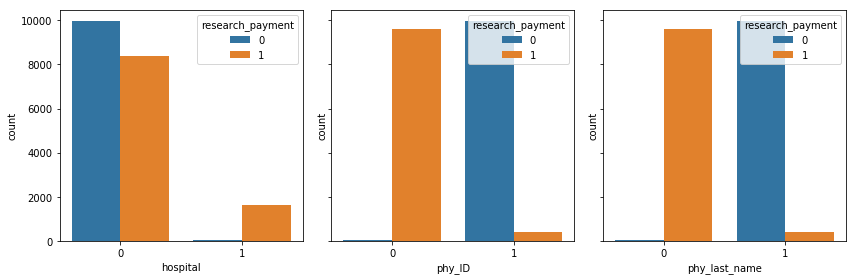

In [227]:
cols_simplify = ['hospital', 'phy_ID', 'phy_last_name']

fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey='row')
i = 0

for c in cols_simplify:
    sns.countplot(np.where(df[c].notnull(), 1, 0), hue=df['research_payment'], ax=ax[i])
    ax[i].set_xlabel(c)
    i+=1
plt.tight_layout()

We can encode these variables to simplify them whilst also preserving any valuable information. By encoding physician ID and last name, we would be creating two identical variables so we can simply drop one of the two.


In [228]:
df['hospital'] = np.where(df.hospital.notnull(), 1, 0)
df['phy_ID'] = np.where(df.phy_ID.notnull(), 1, 0)
df.drop('phy_last_name', axis=1, inplace=True)

For the remaining text variables, it might be a good idea to set all their values to lower case before proceeding in case there are any duplicates that have been skipped. 

In [229]:
for c in df.columns.values[:-1]:
    if df[c].dtype == object:
        df[c] = df[c].str.lower()

**Address**

Almost every observation has a different address, so on first glance this might not be a very useful variable.

In [230]:
df.groupby(['research_payment', 'address']).size().reset_index().iloc[np.r_[0:2, -2:0]]

,research_payment,address,0
0,0,1 associate dr,1
1,0,1 audobon plaza drive,1
13583,1,west texas retina consultant,1
13584,1,wls fargo lockbox duke university accounts rec...,1


It might be worth extracting the notable parts of each address line by looking for some keywords, e.g university, laboratory, medical, hospital etc. 

We'll map all address to either a hospital/lab/uni or other. 

In [231]:
# university
df['address'] = np.where(df.address.str.contains('uni|depart|medic|lab|resear|foundat', regex=True), 'university', df.address)
# hospital
df['address'] = np.where(df.address.str.contains('hosp|clinic', regex=True), 'hospital', df.address)
# other
df['address'] = np.where(df.address.str.contains('hosp|lab|uni', regex=True), df.address, 'other')


In [232]:
df.groupby(['research_payment', 'address']).size().reset_index()

,research_payment,address,0
0,0,hospital,108
1,0,laboratory,12
2,0,other,9565
3,0,university,315
4,1,hospital,87
5,1,laboratory,42
6,1,other,9381
7,1,university,490
